# Processing WGMS mass-balance data for OGGM

In this notebook, we use the most recent lookup table provided by the WGMS to prepare the reference mass-balance data for the OGGM model.

For this to work you'll need the latest lookup table and the latest WGMS FoG data (available [here](http://wgms.ch/data_databaseversions/)), and the latest RGI version (available [here](http://www.glims.org/RGI/)).

In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read the WGMS files

In [3]:
# just download the newest data and change the year / month accordingly. If you run the entire notebook, the oggm-compatible dataset should be compatible
year = '2021'
month = '05'
##
idir = f'DOI-WGMS-FoG-{year}-{month}'
df_links = pd.read_csv(os.path.join(idir, f'WGMS-FoG-{year}-{month}-AA-GLACIER-ID-LUT.csv'), encoding='iso8859_15')
df_mb_all = pd.read_csv(os.path.join(idir, f'WGMS-FoG-{year}-{month}-EE-MASS-BALANCE.csv'), encoding='iso8859_15')

In [4]:
'Total number of links: {}'.format(len(df_links))

'Total number of links: 40781'

In [5]:
df_links = df_links.dropna(subset=['RGI_ID'])  # keep the ones with a valid RGI ID
'Total number of RGI links: {}'.format(len(df_links))

'Total number of RGI links: 35244'

## Select WGMS IDs with more than N years of mass-balance 

In [6]:
df_mb = df_mb_all[df_mb_all.LOWER_BOUND.isin([9999])].copy()  # remove the profiles
gp_id = df_mb.groupby('WGMS_ID')
ids_5 = []
ids_1 = []
for wgmsid, group in gp_id:
    if np.sum(np.isfinite(group.ANNUAL_BALANCE.values)) >= 5:
        ids_5.append(wgmsid)
    if np.sum(np.isfinite(group.ANNUAL_BALANCE.values)) >= 1:
        ids_1.append(wgmsid)

In [7]:
print('Number of glaciers with more than 1 MB years: {}'.format(len(ids_1)))
print('Number of glaciers with more than 5 MB years: {}'.format(len(ids_5)))

Number of glaciers with more than 1 MB years: 482
Number of glaciers with more than 5 MB years: 329


## Number of glaciers in the lookup table with at least 5 years of valid MB data

In [8]:
'Number of matches in the WGMS lookup-table: {}'.format(len(df_links.loc[df_links.WGMS_ID.isin(ids_5)]))

'Number of matches in the WGMS lookup-table: 302'

In [9]:
# keep those
df_links_sel = df_links.loc[df_links.WGMS_ID.isin(ids_5)].copy()

In [10]:
# add some simple stats
df_links_sel['RGI_REG'] = [rid.split('-')[1].split('.')[0] for rid in df_links_sel.RGI_ID]
df_links_sel['N_MB_YRS'] = [len(df_mb.loc[df_mb.WGMS_ID == wid]) for wid in df_links_sel.WGMS_ID]

## Duplicates?

Yes:

In [11]:
df_links_sel.loc[df_links_sel.duplicated('RGI_ID', keep=False)]

,POLITICAL_UNIT,NAME,WGMS_ID,PSFG_ID,WGI_ID,GLIMS_ID,RGI_ID,REMARKS,RGI_REG,N_MB_YRS
405,AQ,DAVIES DOME,10404,NaN,AQ7JRI000055,G301945E63889S,RGI50-19.00707,NaN,19,6
460,AQ,WHISKY GLACIER (IJR-45),10403,NaN,AQ7JRI000125,G301946E63935S,RGI50-19.00707,NaN,19,6
28915,IT,CARESER,635,IT0701,IT4L00102519,NaN,RGI50-11.01834,RGI link checked manually.,11,54
28917,IT,CARESER OCCIDENTALE,3346,NaN,IT4L00100000,NaN,RGI50-11.01834,RGI link checked manually.,11,6
28918,IT,CARESER ORIENTALE,3345,NaN,IT4L00100000,NaN,RGI50-11.01834,RGI link checked manually.,11,6
30438,NO,BLOMSTOELSKARDSBREEN,3339,NO3141,NO4A000AJ009,G353638E59989N,RGI50-08.01436,National glacier ID from Andreassen & Winsvold...,08,11
30764,NO,SVELGJABREEN,3343,NO3137,NO4A000AJ008,G353680E59995N,RGI50-08.01436,National glacier ID from Andreassen & Winsvold...,08,11


Careser is an Italian glacier which is now disintegrated in smaller parts. Here a screenshot from the WGMS exploration tool:

<img src="https://www.dropbox.com/s/a0eoq6rrhimrolu/wgms_1.jpg?dl=1" width="80%">

We keep the oldest MB series and discard the newer ones which are for the smaller glaciers (not represented in RGI).

In [12]:
# We keep CARESER as this is the longest before they split
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([3346, 3345])]

The two norwegian glaciers are part of an ice cap:

<img src="https://www.dropbox.com/s/q6nh7qef4mrf1hz/wgms_2.jpg?dl=1" width="80%">

The two mass-balance time series are very close to each other, unsurprisingly:

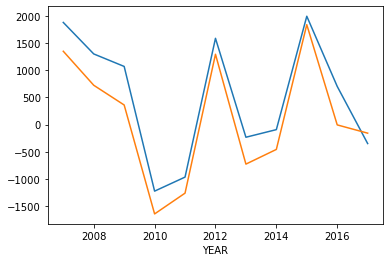

In [13]:
df_mb.loc[df_mb.WGMS_ID.isin([3339])].set_index('YEAR').ANNUAL_BALANCE.plot()
df_mb.loc[df_mb.WGMS_ID.isin([3343])].set_index('YEAR').ANNUAL_BALANCE.plot();

Since there is no reason for picking one series over the other, we have to remove both from the list.

In [14]:
# The two norwegians glaciers are some part of an ice cap. I'll just remove them both
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([3339, 3343])]

In [15]:
df_links_sel.loc[df_links_sel.duplicated('RGI_ID', keep=False)]

,POLITICAL_UNIT,NAME,WGMS_ID,PSFG_ID,WGI_ID,GLIMS_ID,RGI_ID,REMARKS,RGI_REG,N_MB_YRS
405,AQ,DAVIES DOME,10404,NaN,AQ7JRI000055,G301945E63889S,RGI50-19.00707,NaN,19,6
460,AQ,WHISKY GLACIER (IJR-45),10403,NaN,AQ7JRI000125,G301946E63935S,RGI50-19.00707,NaN,19,6


In previous WGMS refmb dataset, there were also two duplicate glaciers in Iceland (WGMS number: 3089 and 3110). Glacier 3110 got apparently removed in the newest refmb dataset. So, no need to remove sth. there!

The Antarctic glaciers link to a huge non-divided ice cap. We simply ignore them: 

In [20]:
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([10404, 10403])]

In [21]:
df_links_sel.loc[df_links_sel.duplicated('RGI_ID', keep=False)]

,POLITICAL_UNIT,NAME,WGMS_ID,PSFG_ID,WGI_ID,GLIMS_ID,RGI_ID,REMARKS,RGI_REG,N_MB_YRS


### Remove suspicious links 

See [PDF document from Betka](https://www.dropbox.com/s/ufh07zq0tfnf805/betka_incorrect_links.pdf?dl=0) + old Urumqi n1:

In [22]:
df_links_sel.loc[df_links_sel.WGMS_ID.isin([3972, 1318, 10401, 1354, 853])]

,POLITICAL_UNIT,NAME,WGMS_ID,PSFG_ID,WGI_ID,GLIMS_ID,RGI_ID,REMARKS,RGI_REG,N_MB_YRS
8228,CL,MOCHO CHOSHUENCO SE,3972,NaN,NaN,NaN,RGI50-17.12685,RGI link automated.,17,11
23892,CN,URUMQI GLACIER NO. 1,853,CN0010,CN5Y730C0029,G086807E43112N,RGI40-13.27055,There is no RGI-ID of the whole glacier (W Bra...,13,62
31368,NO,VESTRE MEMURUBREEN,1318,NO2772,NO4A000AB031,G351546E61542N,RGI60-08.00966,National glacier ID from Andreassen & Winsvold...,08,5
31770,NP,WEST CHANGRI NUP,10401,NaN,NaN,G086808E28006N,RGI60-13.03734,RGI-ID reported by David R. Rounce.,13,9
39322,US,ARAPAHO,1354,US7000,NaN,NaN,RGI60-02.13701,RGI_ID checked and corrected based on feedback...,02,5


We remove these as well:

In [31]:
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([3972, 1318, 10401, 1354, 853])]

### Remove glaciers we can't handle 

WARD H. I. RISE has really bad DEMs:

In [32]:
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([53])]

In [33]:
'Final number of matches in the WGMS lookup-table: {}'.format(len(df_links_sel))

'Final number of matches in the WGMS lookup-table: 290'

## Write out the mass-balance data

In [35]:
#odir = '/home/mowglie/Documents/git/oggm-sample-data/wgms'
# oggm-sample-data/wgms
odir = '.'

### Annual MB

In [36]:
from oggm import utils

In [37]:
utils.mkdir(odir + '/mbdata', reset=True)
for rid, wid in zip(df_links_sel.RGI_ID, df_links_sel.WGMS_ID):
    df_mb_sel = df_mb.loc[df_mb.WGMS_ID == wid].copy()
    df_mb_sel = df_mb_sel[['YEAR', 'WGMS_ID', 'POLITICAL_UNIT', 'NAME', 'AREA', 'WINTER_BALANCE', 
                           'SUMMER_BALANCE',  'ANNUAL_BALANCE', 'REMARKS']].set_index('YEAR')
    df_mb_sel['RGI_ID'] = rid
    df_mb_sel.to_csv(os.path.join(odir, 'mbdata', 'mbdata_WGMS-{:05d}.csv'.format(wid)))

### Profiles

In [38]:
utils.mkdir(odir + '/mb_profiles', reset=True)
for rid, wid in zip(df_links_sel.RGI_ID, df_links_sel.WGMS_ID):
    df_mb_sel = df_mb_all.loc[df_mb_all.WGMS_ID == wid].copy()
    df_mb_sel = df_mb_sel.loc[df_mb_sel.LOWER_BOUND != 9999]
    df_mb_sel = df_mb_sel.loc[df_mb_sel.UPPER_BOUND != 9999]
    if len(df_mb_sel) == 0:
        df_links_sel.loc[df_links_sel.RGI_ID == rid, 'HAS_PROFILE'] = False
        continue
    lb = set()
    for yr in df_mb_sel.YEAR.unique():
        df_mb_sel_yr = df_mb_sel.loc[df_mb_sel.YEAR == yr]
        mids = df_mb_sel_yr.LOWER_BOUND.values*1.
        mids += df_mb_sel_yr.UPPER_BOUND.values[:len(mids)]
        mids *= 0.5
        [lb.add(int(m)) for m in mids]
    prof = pd.DataFrame(columns=sorted(list(lb)), index=sorted(df_mb_sel.YEAR.unique()))
    for yr in df_mb_sel.YEAR.unique():
        df_mb_sel_yr = df_mb_sel.loc[df_mb_sel.YEAR == yr]
        mids = df_mb_sel_yr.LOWER_BOUND.values*1.
        mids += df_mb_sel_yr.UPPER_BOUND.values[:len(mids)]
        mids *= 0.5
        prof.loc[yr, mids.astype(int)] = df_mb_sel_yr.ANNUAL_BALANCE.values
    prof.to_csv(os.path.join(odir, 'mb_profiles', 'profile_WGMS-{:05d}.csv'.format(wid)))
    df_links_sel.loc[df_links_sel.RGI_ID == rid, 'HAS_PROFILE'] = True

## Links: add RGI6 to 5

We use our previous list of links:

In [39]:
ref_df = pd.read_csv(odir + '/rgi_wgms_links_20200414_manual_addition.csv')
len(ref_df), len(df_links_sel)

(267, 290)

In [40]:
df_links_sel_bck = df_links_sel.copy()

In [41]:
for did, rid in df_links_sel[['RGI_ID']].iterrows():
    if 'RGI50' in rid.RGI_ID:
        df_links_sel.loc[did, 'RGI40_ID'] = ''
        df_links_sel.loc[did, 'RGI50_ID'] = rid.RGI_ID
        df_links_sel.loc[did, 'RGI60_ID'] = ''
    elif 'RGI60' in rid.RGI_ID:
        df_links_sel.loc[did, 'RGI40_ID'] = ''
        df_links_sel.loc[did, 'RGI50_ID'] = ''
        df_links_sel.loc[did, 'RGI60_ID'] = rid.RGI_ID
    elif 'RGI40' in rid.RGI_ID:
        df_links_sel.loc[did, 'RGI40_ID'] = rid.RGI_ID
        df_links_sel.loc[did, 'RGI50_ID'] = ''
        df_links_sel.loc[did, 'RGI60_ID'] = ''
    else:
        raise RuntimeError()

### Try to convert the RGI4 ad RGI5 links to RGI6 

In [42]:
for i, r in df_links_sel.iterrows():
    rid4 = r.RGI40_ID
    rid5 = r.RGI50_ID
    rid6 = r.RGI60_ID
    if rid6 != '':
        # check if rgi5 could need as well
        if rid5 == '':
            ref = ref_df.loc[ref_df.RGI60_ID == rid6]
            if len(ref) == 1:
                df_links_sel.loc[i, 'RGI50_ID'] = ref.RGI50_ID.iloc[0]
        continue
    if rid4 != '':
        ref = ref_df.loc[ref_df.RGI40_ID == rid4]
    if rid5 != '':
        ref = ref_df.loc[ref_df.RGI50_ID == rid5]
    if len(ref) == 0:
        # Decide what to do here
        if 'RGI40' in rid4:
            # URUMQI N1 - it is now splitted, just ignore
            raise RuntimeError()
        else:
            # I checked them all: simply take it
            rid6 = rid5.replace('RGI50', 'RGI60')
            # Check
#             sh5 = utils.get_rgi_glacier_entities([rid5], version='50')
#             sh6 = utils.get_rgi_glacier_entities([rid5.replace('RGI50', 'RGI60')], version='60')
#             f, (ax1, ax2) = plt.subplots(1, 2)
#             sh5.plot(ax=ax1)
#             sh6.plot(ax=ax2)
    else:
        rid6 = ref.RGI60_ID.iloc[0]
    df_links_sel.loc[i, 'RGI60_ID'] = rid6

Last check:

In [43]:
df_links_sel.loc[df_links_sel.duplicated('RGI60_ID', keep=False)]

,POLITICAL_UNIT,NAME,WGMS_ID,PSFG_ID,WGI_ID,GLIMS_ID,RGI_ID,REMARKS,RGI_REG,N_MB_YRS,HAS_PROFILE,RGI40_ID,RGI50_ID,RGI60_ID


## Some stats 

In [45]:
# Get the RGI
#df_rgi = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_allglaciers_stats.h5'))
df_rgi = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))

In [46]:
# add lons and lats and other attrs to the WGMS ones
smdf = df_rgi.loc[df_links_sel.RGI60_ID]
df_links_sel['CenLon'] = smdf.CenLon.values
df_links_sel['CenLat'] = smdf.CenLat.values
df_links_sel['GlacierType'] = smdf.GlacierType.values
df_links_sel['TerminusType'] = smdf.TerminusType.values
df_links_sel['IsTidewater'] = smdf.IsTidewater.values

In [47]:
# add region names
sr = gpd.read_file(utils.get_rgi_dir(version='62') + '/00_rgi62_regions/00_rgi62_O1Regions.shp')
sr['RGI_CODE'] = ['{:02d}'.format(int(s)) for s in sr['RGI_CODE']]
sr = sr.drop_duplicates(subset='RGI_CODE')
sr = sr.set_index('RGI_CODE')
sr['FULL_NAME'] = [s + ': ' + n for s, n in sr.FULL_NAME.items()]
df_links_sel['RGI_REG_NAME'] = sr.loc[df_links_sel.RGI_REG].FULL_NAME.values
df_rgi['RGI_REG_NAME'] = sr.loc[df_rgi.O1Region].FULL_NAME.values

In [48]:
df_links_sel = df_links_sel[['CenLon', 'CenLat',
                             'POLITICAL_UNIT', 'NAME', 'WGMS_ID', 'PSFG_ID', 'WGI_ID', 'GLIMS_ID',
                             'RGI40_ID', 'RGI50_ID', 'RGI60_ID', 'RGI_REG', 'RGI_REG_NAME', 
                             'GlacierType', 'TerminusType', 
                             'IsTidewater', 'N_MB_YRS', 'HAS_PROFILE', 'REMARKS']]
df_links_sel.to_csv(os.path.join(odir, 'rgi_wgms_links_20200415.csv'.format(wid)), index=False)

## Some plots 

In [49]:
import seaborn as sns
# sns.set_context('talk')
sns.set_style('whitegrid')
pdir = odir+'/plots'
utils.mkdir(pdir)

'./plots'

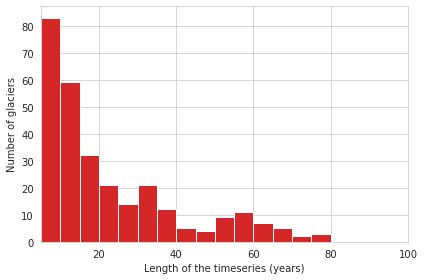

In [50]:
df_links_sel['N_MB_YRS'].plot(kind='hist', color='C3', bins=np.arange(21)*5);
plt.xlim(5, 100);
plt.ylabel('Number of glaciers')
plt.xlabel('Length of the timeseries (years)');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'nglacier-hist.png'), dpi=150)

83
126
81


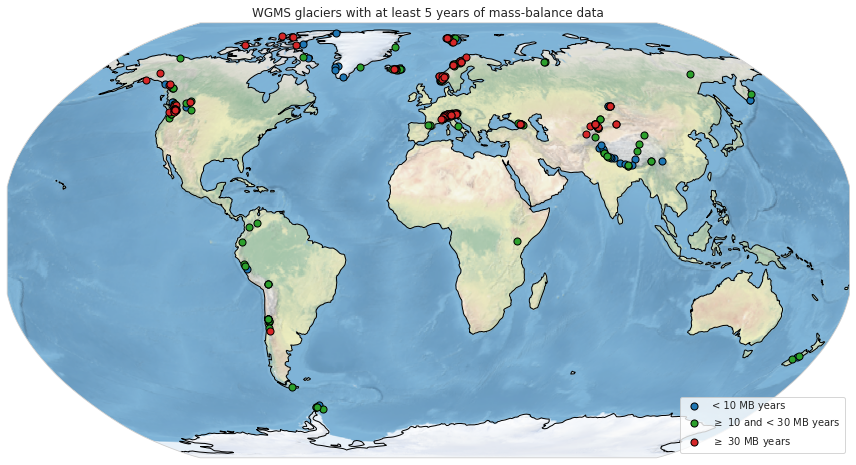

In [51]:
import cartopy
import cartopy.crs as ccrs

f = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.Robinson())
# mark a known place to help us geo-locate ourselves
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.COASTLINE);
s = df_links_sel.loc[df_links_sel.N_MB_YRS < 10]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='< 10 MB years', s=50,
           edgecolor='k', facecolor='C0', transform=ccrs.PlateCarree(), zorder=99)
s = df_links_sel.loc[(df_links_sel.N_MB_YRS >= 10) & (df_links_sel.N_MB_YRS < 30)]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='$\geq$ 10 and < 30 MB years', s=50,
           edgecolor='k', facecolor='C2', transform=ccrs.PlateCarree(), zorder=99)
s = df_links_sel.loc[df_links_sel.N_MB_YRS >= 30]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='$\geq$ 30 MB years', s=50,
           edgecolor='k', facecolor='C3', transform=ccrs.PlateCarree(), zorder=99)
plt.title('WGMS glaciers with at least 5 years of mass-balance data')
plt.legend(loc=4, frameon=True)
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'glacier-map.png'), dpi=150)

In [52]:
df_links_sel.TerminusType.value_counts().to_frame()

,TerminusType
Land-terminating,281
Marine-terminating,9


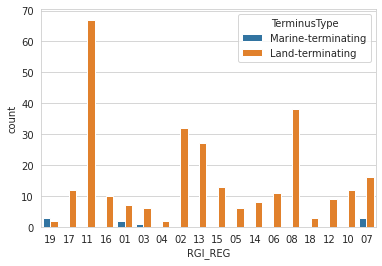

In [53]:
ax = sns.countplot(x='RGI_REG', hue="TerminusType", data=df_links_sel);

In [54]:
md = pd.concat([df_rgi.GlacierType.value_counts().to_frame(name='RGI V6').T, 
                df_links_sel.GlacierType.value_counts().to_frame(name='WGMS').T]
          ).T
md

,RGI V6,WGMS
Glacier,209328,272
Ice cap,7174,18


In [55]:
md = pd.concat([df_rgi.TerminusType.value_counts().to_frame(name='RGI V6').T, 
                df_links_sel.TerminusType.value_counts().to_frame(name='WGMS').T],
                sort=False).T
md

,RGI V6,WGMS
Land-terminating,212813.0,281.0
Marine-terminating,3222.0,9.0
Lake-terminating,298.0,NaN
Shelf-terminating,169.0,NaN


In [56]:
area_per_reg = df_rgi[['Area', 'RGI_REG_NAME']].groupby('RGI_REG_NAME').sum()
area_per_reg['N_WGMS'] = df_links_sel.RGI_REG_NAME.value_counts()
area_per_reg = area_per_reg.reset_index()

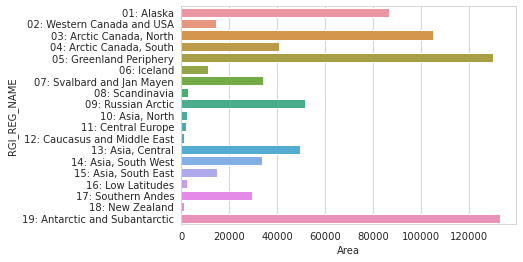

In [57]:
sns.barplot(x="Area", y="RGI_REG_NAME", data=area_per_reg);

In [58]:
area_per_reg['N_WGMS_PER_UNIT'] = area_per_reg.N_WGMS / area_per_reg.Area * 1000

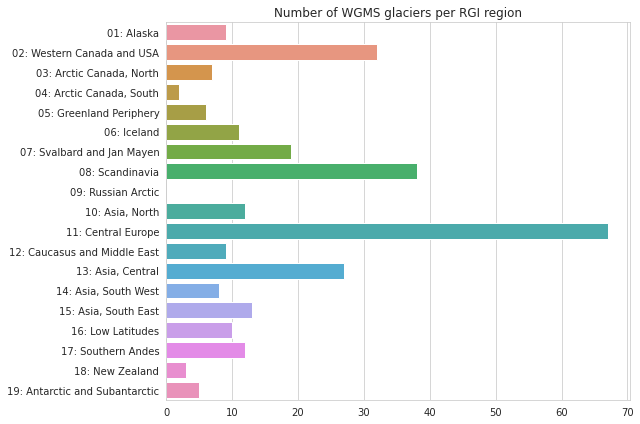

In [59]:
plt.figure(figsize=(9, 6))
sns.barplot(x="N_WGMS", y="RGI_REG_NAME", data=area_per_reg);  # , palette=sns.husl_palette(19, s=.7, l=.5)
plt.ylabel('')
plt.xlabel('')
plt.title('Number of WGMS glaciers per RGI region');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'barplot-ng.png'), dpi=150)

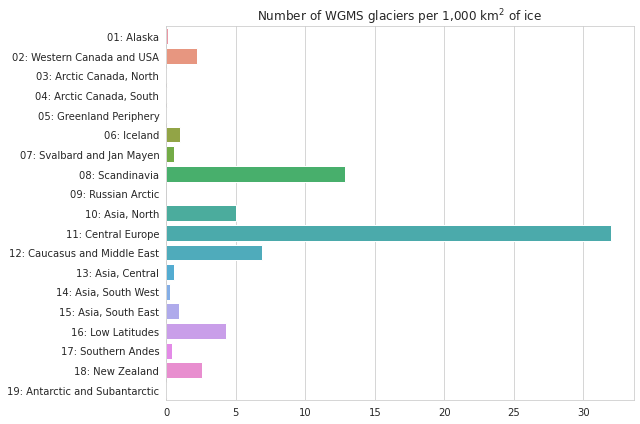

In [60]:
plt.figure(figsize=(9, 6))
sns.barplot(x="N_WGMS_PER_UNIT", y="RGI_REG_NAME", data=area_per_reg);
plt.ylabel('')
plt.xlabel('')
plt.title('Number of WGMS glaciers per 1,000 km$^2$ of ice');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'barplot-perice.png'), dpi=150)

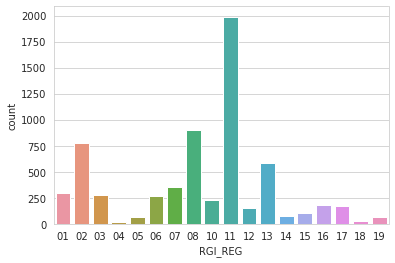

In [61]:
nmb_yrs = df_links_sel[["RGI_REG", 'N_MB_YRS']].groupby("RGI_REG").sum()
i = []
for k, d in nmb_yrs.iterrows():
     i.extend([k] * d.values[0])
df = pd.DataFrame()
df["RGI_REG"] = i
ax = sns.countplot(x="RGI_REG", data=df)